# Paso 1: Lectura del Archivo de Texto

- Función: Abre un archivo de texto llamado enwiki-20240401-1.txt en modo de lectura
- Propósito: Leer todo el contenido del archivo y almacenarlo en la variable content para su posterior procesamiento.

In [119]:
with open("ArchivosWiki/enwiki-20240401-99.txt", "r") as file:
    content = file.read()
print(content)

[[Squad automatic weapon]]

CATEGORIES: Squad automatic weapons

A squad automatic weapon (SAW), also known as a section automatic weapon or light support weapon (LSW), is a man-portable automatic firearm attached to infantry squads or sections as a source of rapid direct firepower. Weapons fulfilling this role can be light machine guns, or modified selective-fire rifles fitted with a heavier barrel, bipod and a belt/drum-fed design.

Squad automatic weapons usually fire the same cartridge (though heavier-bullet variants are preferred) as the assault rifles or battle rifles carried by other members of the unit. This reduces logistical requirements by making it only necessary to supply one type of service ammunition to a unit. These weapons are light enough to be carried and operated by one infantryman, unlike medium machine guns (such as the M1919 Browning) that require a crew to operate at full effectiveness; or heavy machine guns (such as the M2 Browning or the DShK) which fire more 

# Paso 2: Funciones de Limpieza de Texto

In [120]:
import re
# Funciones de limpieza
def remove_newlines_and_whitespace(text):
     # Elimina nuevas líneas y reemplaza con espacio
    text = re.sub(r'[\r\n]+', ' ', text)
    # Convierte múltiples espacios a un solo espacio y elimina espacios en los extremos
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_unwanted_characters(text):
    # Elimina caracteres de puntuación y especiales
    text = re.sub(r'[^\w\s]', '', text)
    return text

def normalize_text(text):
     # Convierte el texto a minúsculas
    text = text.lower()
    return text

- remove_newlines_and_whitespace: Elimina saltos de línea y espacios en blanco adicionales, reemplazándolos por un solo espacio.
- remove_unwanted_characters: Elimina caracteres de puntuación y especiales.
- normalize_text: Convierte el texto a minúsculas.


# Paso 3: Aplicación de las Funciones de Limpieza


In [121]:
import pandas as pd
# Aplicar funciones de limpieza en secuencia
cleaned_content = normalize_text(remove_unwanted_characters(remove_newlines_and_whitespace(content)))
#df = pd.DataFrame({'text': [remove_newlines(content)]})
# Crear el DataFrame de pandas
df = pd.DataFrame({'text': [cleaned_content]})
df.to_csv('processed.csv', index=False)
df.head()

,text
0,squad automatic weapon categories squad automa...


- Función: Aplica las funciones de limpieza al contenido del texto.
- Propósito: Crear un DataFrame de pandas con el texto limpio y guardarlo en un archivo CSV llamado processed.csv.

# Paso 4: Tokenización del Texto

- Función: Usa un tokenizer para convertir el texto en tokens y cuenta cuántos tokens hay en cada entrada del DataFrame.
- Propósito: Analizar la distribución de tokens en el texto, lo cual es útil para entender el tamaño y complejidad del texto.

<Axes: >

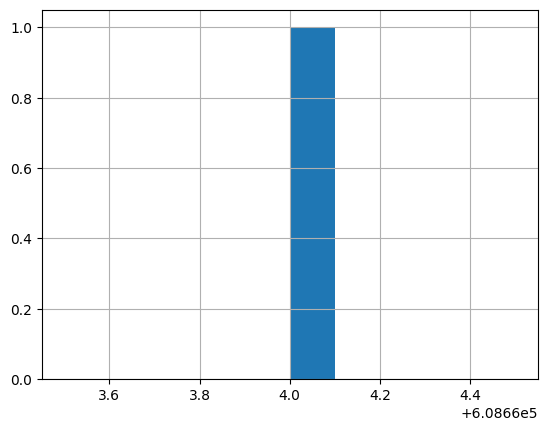

In [122]:
import tiktoken
import matplotlib
tokenizer = tiktoken.get_encoding("cl100k_base")
df = pd.read_csv('processed.csv')
df.columns = ['text']
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

# Paso 5: División del Texto en Fragmentos
- Función: Divide el texto en fragmentos de un tamaño máximo de tokens.
- Propósito: Preparar el texto para su procesamiento en modelos de lenguaje, asegurando que cada fragmento sea manejable y no exceda la capacidad del modelo.

In [123]:
max_tokens = 150
# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):
    # Split the text into sentences
    sentences = text.split('.\n')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    chunks = []
    tokens_so_far = 0
    chunk = []
    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):
        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0
        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue
        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1
    return chunks
# shortened = []

# shortened = split_into_many(content)
shortened = []
# print(shortened)
# print(len(shortened))
for row in df.iterrows():
    if row[1]['text'] is None:
        continue
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(content)
    else:
        shortened.append(content)

- El propósito de este fragmento es analizar y visualizar la distribución del tamaño de los fragmentos de texto en términos de tokens. Esto es útil para entender cómo se distribuyen los datos y asegurarse de que los fragmentos no excedan el límite de tokens que puede manejar el modelo de lenguaje que se está utilizando. Además, esta información puede ser útil para ajustar el tamaño de los fragmentos si es necesario.

<Axes: >

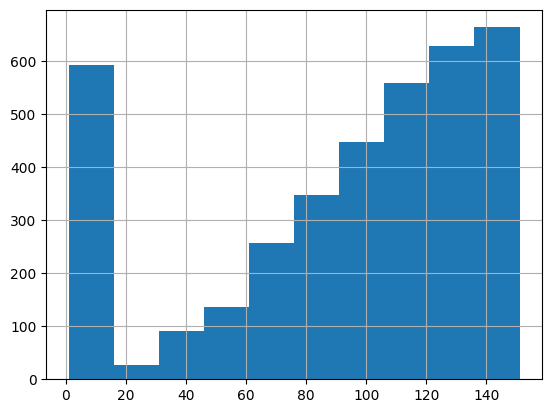

In [124]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

# Paso 6: Obtener Embeddings
- Función: Usa un modelo de embedding para convertir cada fragmento de texto en un vector de números.
- Propósito: Crear representaciones numéricas de los fragmentos de texto, lo cual es necesario para su uso en modelos de lenguaje.


In [125]:
from openai import OpenAI
import os

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding


df['embeddings'] = df.text.apply(lambda x: get_embedding(x, model='text-embedding-3-small'))
df.to_csv('embedings.csv', index=False)
df.head()

,text,n_tokens,embeddings
0,[[Squad automatic weapon]]\n\nCATEGORIES: Squa...,88,"[0.019911184906959534, 0.020149214193224907, -..."
1,\nSquad automatic weapons usually fire the sam...,134,"[0.0041562519036233425, 0.022512286901474, 0.0..."
2,\nAnother pioneering weapon in this role was t...,145,"[0.0028823474422097206, 0.039588093757629395, ..."
3,\nModern squad automatic weapons (such as the ...,148,"[-0.005136732943356037, 0.025281604379415512, ..."
4,"\nLight machine guns, either belt-fed or magaz...",87,"[-0.000202961266040802, 0.02911568246781826, -..."


# Calcular Distancias y Crear Contexto para Preguntas
- Este fragmento de código está diseñado para cargar un archivo CSV que contiene embeddings de texto y prepararlos para su uso en cálculos de similitud. 
- El propósito de este fragmento es preparar los embeddings para cálculos de similitud. Al convertir los embeddings en arrays de numpy, puedes realizar operaciones matemáticas, como calcular la distancia coseno, para medir la similitud entre diferentes fragmentos de texto. Esto es crucial para tareas como encontrar el contexto más relevante para una pregunta, como se hace en el resto del código.

In [16]:
import numpy as np
from scipy.spatial.distance import cosine

df=pd.read_csv('embedings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
df.head()



,n_tokens,embeddings
text,,
"[[Horses (album)]]\n\nCATEGORIES: 1975 debut albums, Patti Smith albums, Albums produced by John Cale, Albums recorded at Electric Lady Studios, Arista Records albums, Grammy Hall of Fame Award recipients, United States National Recording Registry recordings, United States National Recording Registry albums\n\nHorses is the debut studio album by American musician Patti Smith. It was released by Arista Records on November 10, 1975. A fixture of the mid-1970s underground rock music scene in New York City, Smith signed to Arista in 1975 and recorded Horses with her band at Electric Lady Studios in August and September of that year. She enlisted former Velvet Underground member John Cale to produce the album.",151,"[-0.02913784421980381, -0.007463001646101475, ..."
"\nThe music on Horses was informed by the minimalist aesthetic of the punk rock genre, then in its formative years. Smith and her band composed the album's songs using simple chord progressions, while also breaking from punk tradition in their propensity for improvisation and embrace of ideas from avant-garde and other musical styles. Smith's lyrics on Horses were alternately rooted in her own personal experiences, particularly with her family, and in more fantastical imagery. The album also features adaptations of the rock standards ""Gloria"" and ""Land of a Thousand Dances"".",116,"[-0.025254597887396812, 0.02342325635254383, 0..."
"\nAt the time of its release, Horses experienced modest commercial success and placed in the top 50 of the American Billboard 200 albums chart, while being widely acclaimed by music critics. Recognized as a seminal recording in the history of punk and later rock movements, Horses has frequently appeared in professional lists of the greatest albums of all time. In 2009, it was selected by the Library of Congress for preservation into the National Recording Registry as a ""culturally, historically, or aesthetically significant"" work.",106,"[-0.001361982082016766, 0.010141624137759209, ..."
"\n==Background==\n\nThrough frequent live performances over the previous year, by 1975 Patti Smith and her band had established themselves as a popular act within the New York City underground rock music scene. Further increasing their popularity was their highly attended two-month residency at the New York City club CBGB with the band Television early that year. The hype surrounding the residency brought Smith to the attention of music industry executive Clive Davis, who was scouting for talent to sign to his recently launched label Arista Records. After being impressed by one of her live performances at CBGB, Davis offered Smith a seven-album recording deal with Arista, and she signed to the label in April 1975.",140,"[-0.0017797661712393165, -0.04998353496193886,..."
.,1,"[0.025898044928908348, 0.02504582516849041, 0...."


# Paso 7: Crear Contexto para Preguntas
- Función: Encuentra el fragmento de texto más similar al texto de la pregunta.
- Propósito: Proporcionar contexto relevante para la pregunta, lo cual es crucial para obtener respuestas precisas.


In [126]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    q_embeddings = get_embedding(question)
    # q_embeddings = client.embeddings.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
    # Get the distances from the embeddings
    df["distances"] = df["embeddings"].apply(lambda x: cosine(q_embeddings, x))

    returns = []
    cur_len = 0
    
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        cur_len += row['n_tokens'] + 4
        if cur_len > max_len:
            break
        returns.append(str(i))
    return ", ".join(returns)


# Paso 8: Responder Preguntas
- Función: Usa un modelo de lenguaje para responder a la pregunta utilizando el contexto encontrado.
- Propósito: Proporcionar una respuesta precisa y relevante a la pregunta basada en el contexto.


In [127]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=500,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Contexto:\n")
        print(context)
        print("\n\n")

    try:
        # Create a chat completion using the question and context
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Responde la pregunta basandote en el contexto, hazlo de manera clara. Si no puedes reponder basado en el contexto, solamente di 'Escribe AGENTE para más información.'"},
                {"role": "system", "content": f"contexto: {context}"},
                {"role": "user", "content": f"pregunta: {question}"},
                {"role": "assistant", "content": "respuesta:"}
                # {"role": "user", f"content": "Contexto: {context}\n\n---\n\nPregunta: {question}\nRespuesta:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

# Paso 9: Pruebas

In [36]:
answer_question(df, question="What are the main themes?", max_tokens=100)

'Los temas principales son el feminismo, el ambientalismo, el pacifismo, el amor y la familia en las obras de Miyazaki. También se mencionan temas de supervivencia humana en Marte, como la colonización, la terraformación y las historias de pura supervivencia.'

In [198]:
answer_question(df, question="What does it say about nature?")

'The text emphasizes the importance of nature in art and language, highlighting concerns about the negative impact of industrialization on the natural world. It mentions the natural hazards and environmental issues faced, such as high winds, rough seas, dense fog, air pollution, marine pollution, and waste disposal. Additionally, it discusses the natural vegetation of the Ithaca area, which consists of northern temperate broadleaf forest dominated by deciduous and coniferous trees.'

In [28]:
answer_question(df, question="What does it say about the economy?", max_tokens=100)

'El texto menciona que Albania ha tenido éxito en la transición de una economía planificada socialista a una economía mixta capitalista. Se clasifica como una economía de ingresos medios altos por el Banco Mundial y en 2016 tenía la cuarta tasa de desempleo más baja en los Balcanes. Sus principales socios comerciales son Italia, Grecia, China, España, Kosovo y Estados Unidos. La moneda del país'

In [29]:
answer_question(df, question="Are you talking about economics?", max_tokens=100)

'Sí, se está hablando sobre temas relacionados con la economía en el contexto proporcionado.'

In [30]:
answer_question(df, question="What is the atomic number", max_tokens=100)

'El número atómico es el número de carga nuclear de un elemento químico, es decir, es igual al número de protones que se encuentran en el núcleo de cada átomo de ese elemento. También se puede utilizar para identificar de manera única los elementos químicos ordinarios.'

# LECTURA DE LOS ARCHIVOS GENERADOS

In [1]:
import os
import pandas as pd
import numpy as np
from openai import OpenAI
from scipy.spatial.distance import cosine
from dotenv import load_dotenv

# Configura tu clave de API de OpenAI
client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    q_embeddings = get_embedding(question)
    # q_embeddings = client.embeddings.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
    # Get the distances from the embeddings
    df["distances"] = df["embeddings"].apply(lambda x: cosine(q_embeddings, x))

    returns = []
    cur_len = 0
    
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        cur_len += row['n_tokens'] + 4
        if cur_len > max_len:
            break
        returns.append(str(i))
    return ", ".join(returns)


def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="",
    max_len=500,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Contexto:\n")
        print(context)
        print("\n\n")

    try:
        # Create a chat completion using the question and context
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Responde la pregunta basandote en el contexto, hazlo de manera clara. Si no puedes reponder basado en el contexto, solamente di 'Escribe AGENTE para más información.'"},
                {"role": "system", "content": f"contexto: {context}"},
                {"role": "user", "content": f"pregunta: {question}"},
                {"role": "assistant", "content": "respuesta:"}
                # {"role": "user", f"content": "Contexto: {context}\n\n---\n\nPregunta: {question}\nRespuesta:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

# Leer todos los archivos CSV y concatenarlos en un solo DataFrame
directory = 'ResultEmbeddings'
all_embeddings = []
full_df = pd.DataFrame()

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        if 'embeddings' in df.columns:
            df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
            all_embeddings.append(df)
        else:
            print(f"'embeddings' column not found in {filename}")

if all_embeddings:
    full_df = pd.concat(all_embeddings, ignore_index=True)
else:
    full_df = pd.DataFrame()



# PREGUNTAS FACTUALES

In [2]:
# Lista de preguntas
questions = [
    "Who painted the Mona Lisa?",
    "What is the capital of France?",
    "When did World War II begin?",
    "Who was the first man to walk on the Moon?",
    "What is the longest river in the world?",
    "Which country has the largest population?",
    "Who wrote 'One Hundred Years of Solitude'?",
    "What chemical element has the symbol 'O'?",
    "In what year was America discovered?",
    "What is the highest mountain in the world?",
    "Who is the author of the theory of relativity?",
    "What is the largest ocean in the world?",
    "Which country won the 2018 FIFA World Cup?",
    "Which planet is known as the Red Planet?",
    "Who was the first president of the United States?",
    "How many colors are in a rainbow?",
    "On which continent is Egypt located?",
    "What language is spoken in Brazil?",
    "What currency is used in Japan?",
    "What language is spoken in Japan?"
]

# Iterar sobre las preguntas y obtener respuestas
for i, question in enumerate(questions, 1):
    print(f"\nPregunta {i}: {question}")
    response = answer_question(full_df, question=question)
     # Imprimir la respuesta generada
    print(f"Respuesta: {response}")



Pregunta 1: Who painted the Mona Lisa?
Respuesta: Leonardo da Vinci.

Pregunta 2: What is the capital of France?
Respuesta: La capital de Francia es París.

Pregunta 3: When did World War II begin?
Respuesta: Escribe AGENTE para más información.

Pregunta 4: Who was the first man to walk on the Moon?
Respuesta: Neil Armstrong was the first man to walk on the Moon.

Pregunta 5: What is the longest river in the world?
Respuesta: El río Amazonas.

Pregunta 6: Which country has the largest population?
Respuesta: Escribe AGENTE para más información.

Pregunta 7: Who wrote 'One Hundred Years of Solitude'?
Respuesta: Gabriel García Márquez wrote 'One Hundred Years of Solitude'.

Pregunta 8: What chemical element has the symbol 'O'?
Respuesta: El elemento químico con el símbolo 'O' es el oxígeno.

Pregunta 9: In what year was America discovered?
Respuesta: Escribe AGENTE para más información.

Pregunta 10: What is the highest mountain in the world?
Respuesta: Mount Everest is the highest moun

# PREGUNTAS CONTEXTUALES

In [3]:
# Lista de preguntas
questions = [
    "What does 'Python' mean in programming?",
    "What does 'Python' mean in zoology?",
    "What is Java in computer science?",
    "What is Java in geography?",
    "What is the connection between the Sun and photosynthesis?",
    "How does global warming affect sea levels?",
    "What does the melting of polar ice caps imply?",
    "What is the impact of climate change on agriculture?",
    "What are the benefits of artificial intelligence in medicine?",
    "What does 'bank' mean in the financial context?",
    "What does 'bank' mean in the context of a park?",
    "How is electricity related to magnetism?",
    "What is quantum computing and how is it used?",
    "How is cryptocurrency defined?",
    "What role does water play in the life cycle?",
    "What does the 'Industrial Revolution' mean in historical terms?",
    "What is the relationship between capitalism and the free market?",
    "What does 'blockchain' mean in the technological context?",
    "What is the importance of photosynthesis in nature?",
    "What role does education play in economic development?"
]

# Iterar sobre las preguntas y obtener respuestas
for i, question in enumerate(questions, 1):
    print(f"\nPregunta {i}: {question}")
    response = answer_question(full_df, question=question)
     # Imprimir la respuesta generada
    print(f"Respuesta: {response}")



Pregunta 1: What does 'Python' mean in programming?
Respuesta: 'Python' es un lenguaje de programación de alto nivel conocido por su sintaxis clara y legible. Es ampliamente utilizado en diversas áreas como desarrollo web, análisis de datos, inteligencia artificial, entre otros.

Pregunta 2: What does 'Python' mean in zoology?
Respuesta: Escribe AGENTE para más información.

Pregunta 3: What is Java in computer science?
Respuesta: Java is a high-level programming language commonly used in computer science for developing applications, software, and web content. It is known for its platform independence, object-oriented programming features, and robustness.

Pregunta 4: What is Java in geography?
Respuesta: Escribe AGENTE para más información.

Pregunta 5: What is the connection between the Sun and photosynthesis?
Respuesta: La conexión entre el Sol y la fotosíntesis es que la fotosíntesis es un proceso mediante el cual las plantas utilizan la energía del Sol para convertir dióxido de c

In [2]:
print(full_df.head())
full_df.head()

                                                text  n_tokens  \
0  [[AIM (software)]]\n\nCATEGORIES: 1997 softwar...       144   
1  \nAIM was popular by the late 1990s, in United...       150   
2  \nIn June 2015, AOL was acquired by Verizon Co...        53   
3  \n==History==\n\nIn May 1997, AIM was released...       115   
4  \nDuring its heyday, its main competitors were...       120   

                                          embeddings  distances  
0  [0.008112572133541107, -0.013291715644299984, ...   0.885002  
1  [0.038160696625709534, -0.006582450587302446, ...   0.854775  
2  [0.028669197112321854, -0.037410952150821686, ...   0.931589  
3  [0.02951241098344326, -0.01395278237760067, 0....   0.904801  
4  [0.011332163587212563, -0.04812916740775108, 0...   0.854939  


,text,n_tokens,embeddings,distances
0,[[AIM (software)]]\n\nCATEGORIES: 1997 softwar...,144,"[0.008112572133541107, -0.013291715644299984, ...",0.885002
1,"\nAIM was popular by the late 1990s, in United...",150,"[0.038160696625709534, -0.006582450587302446, ...",0.854775
2,"\nIn June 2015, AOL was acquired by Verizon Co...",53,"[0.028669197112321854, -0.037410952150821686, ...",0.931589
3,"\n==History==\n\nIn May 1997, AIM was released...",115,"[0.02951241098344326, -0.01395278237760067, 0....",0.904801
4,"\nDuring its heyday, its main competitors were...",120,"[0.011332163587212563, -0.04812916740775108, 0...",0.854939


# ANALOGIAS

In [16]:
from scipy.spatial.distance import cosine

def find_analogy_in_texts_with_gpt(
    word_a,
    word_b,
    word_c,
    df,
    gpt_model="gpt-3.5-turbo",
    max_tokens=150,
    top_n=3,
    debug=False
):
    """
    Encuentra el texto más relevante que completa la analogía usando embeddings del DataFrame y GPT.

    Parámetros:
        word_a (str): Primera palabra en la analogía (e.g., "king").
        word_b (str): Segunda palabra en la analogía (e.g., "queen").
        word_c (str): Tercera palabra en la analogía (e.g., "man").
        df (DataFrame): DataFrame con columnas 'embeddings' y 'text'.
        gpt_model (str): Modelo GPT a usar (por defecto: "gpt-3.5-turbo").
        max_tokens (int): Número máximo de tokens en la respuesta.
        top_n (int): Número de textos más cercanos a retornar.
        debug (bool): Si es True, imprime información adicional para depuración.

    Retorna:
        str: Respuesta refinada por GPT para completar la analogía.
    """
    try:
        # Obtener embeddings de las palabras de entrada usando GPT u otro método
        embedding_a = get_embedding(word_a)  # Obtén el embedding de GPT o tu método configurado
        embedding_b = get_embedding(word_b)
        embedding_c = get_embedding(word_c)

        # Calcular el vector de analogía
        analogy_vector = np.array(embedding_a) - np.array(embedding_b) + np.array(embedding_c)

        # Calcular las similitudes con los textos en el DataFrame
        df["similarity"] = df["embeddings"].apply(lambda x: 1 - cosine(analogy_vector, x))

        # Ordenar por similitud
        top_results = df.sort_values(by="similarity", ascending=False).head(top_n)

        # Combinar los textos más relevantes
        context = "\n".join(top_results["text"])

        if debug:
            print("Resultados más cercanos:")
            print(context)

        # Crear un prompt para GPT con los resultados obtenidos
        prompt = (
            f"La analogía es: '{word_a}' es a '{word_b}' como '{word_c}' es a ¿qué?\n"
            f"Los textos relevantes son:\n{context}\n"
            f"Basándote en estos textos, completa la analogía con una explicación breve."
        )

        # Llamar al modelo GPT para refinar la respuesta
        response = client.chat.completions.create(
            model=gpt_model,
            messages=[
                {
                    "role": "system",
                    "content": "Completa la analogía usando los textos proporcionados. Da una respuesta clara y breve."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )

        # Extraer y retornar la respuesta de GPT
        answer = response.choices[0].message.content.strip()
        if debug:
            print("Prompt enviado a GPT:\n", prompt)
            print("\nRespuesta generada por GPT:\n", answer)

        return answer

    except Exception as e:
        print(f"Error al procesar la analogía: {e}")
        return "Error al generar la analogía."




Resultados más cercanos:

In particular, masculine nouns ending with a palatal or prepalatal consonant j, lj, nj, č, dž, ć, đ or š form vocatives with the -u suffix: heroj : heroju hero, prijatelj : prijatelju friend, konj : konju horse, vozač : vozaču driver, mladić : mladiću youngster, kočijaš : kočijašu coachman, muž : mužu husband.

Some scholars identify the lion-man as Aion, or Zurvan, or Cronus, or Chronos, while others assert that it is a version of the Zoroastrian Ahriman or the more benign Vedic Aryaman.

In Swedish (which has an overall common–neuter gender system), masculinity may be argued to be a marked feature, because in the weak adjectival declension there is a distinct ending (-e) for naturally masculine nouns (as in min lillebror, "my little brother"). In spite of this, the third-person singular masculine pronoun han would normally be the default for a person of unknown gender, although in practice the indefinite pronoun man and the reflexive sig or its possessive fo

In [18]:
# Ejemplo de uso
word_a = "king"
word_b = "queen"
word_c = "man"


result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")


'king' es a 'queen' como 'man' es a: La analogía sería: 'king' es a 'queen' como 'man' es a 'woman'. En ambos casos se trata de pares de palabras que representan géneros opuestos.


In [19]:
word_a = "madrid"
word_b = "spain"
word_c = "tokio"

result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")


'madrid' es a 'spain' como 'tokio' es a: La analogía completa sería: 'Tokio' es a 'Japón'. Ambas ciudades son capitales importantes de sus respectivos países y representan centros financieros, culturales y de influencia a nivel internacional.


In [20]:
word_a = "day"
word_b = "sunny"
word_c = "night"

result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")

'day' es a 'sunny' como 'night' es a: La analogía completa sería: 'day' es a 'sunny' como 'night' es a 'dark'. Durante el día, generalmente hay luz solar y se asocia con el término "sunny", mientras que durante la noche, la ausencia de luz solar se relaciona con la oscuridad.


In [21]:
word_a = "spoon"
word_b = "soup"
word_c = "fork"

result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")

'spoon' es a 'soup' como 'fork' es a: 'Fork' es a 'salad' como 'spoon' es a 'sopa'. Los tenedores se utilizan comúnmente para comer ensaladas, al igual que las cucharas se utilizan comúnmente para comer sopa.


In [22]:
word_a = "apple"
word_b = "fruit"
word_c = "dog"

result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")

'apple' es a 'fruit' como 'dog' es a: La analogía es: 'apple' es a 'fruit' como 'dog' es a 'animal'. En ambos casos, se menciona un ejemplo específico de una categoría más amplia. En el primer caso, la manzana es un tipo de fruta, y en el segundo caso, el perro es un tipo de animal.


In [23]:
word_a = "eye"
word_b = "see"
word_c = "ear"

result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")

'eye' es a 'see' como 'ear' es a: La analogía completa sería: 'ear' es a 'hear'. Así como el ojo está relacionado con la vista, el oído está relacionado con la audición.


In [24]:
word_a = "car"
word_b = "fuel"
word_c = "human"

result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")

'car' es a 'fuel' como 'human' es a: La analogía completa sería: 'car' es a 'fuel' como 'human' es a 'food'. En ambos casos, el combustible es necesario para el funcionamiento y energía, respectivamente.


In [25]:
word_a = "bird"
word_b = "flying"
word_c = "fish"

result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")

'bird' es a 'flying' como 'fish' es a: La analogía completa sería: 'fish' es a 'swimming'. Los peces nadan en el agua, al igual que las aves vuelan en el aire.


In [26]:
word_a = "computer"
word_b = "processor"
word_c = "human"

result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")

'computer' es a 'processor' como 'human' es a: La analogía completa sería: 'computer' es a 'processor' como 'human' es a 'Homo sapiens'. En ambos casos, el segundo término se refiere a la entidad específica dentro de la categoría más amplia. En el caso de 'computer' y 'processor', el procesador es una parte específica de la computadora, al igual que 'Homo sapiens' es una especie específica dentro de la categoría más amplia de 'human'.


In [27]:
word_a = "book"
word_b = "read"
word_c = "movie"

result = find_analogy_in_texts_with_gpt(
    word_a=word_a,
    word_b=word_b,
    word_c=word_c,
    df=full_df,
    gpt_model="gpt-3.5-turbo",
    debug=False
)

print(f"'{word_a}' es a '{word_b}' como '{word_c}' es a: {result}")

'book' es a 'read' como 'movie' es a: La analogía completa sería: 'movie' es a 'watch'. En ambos casos se trata de la acción que se realiza con respecto a un libro o película, respectivamente.
